In [40]:
from pulp import *
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [41]:
def add_enough_workers_constraint(prob: pulp.LpProblem, p_vars: list, num_employees: int, num_days: int, num_shifts_per_day: int):
    #for each day...
    for d in range(num_days):
        #make sure that enough people are working
        prob += sum([p_vars[i][d] for i in range(num_employees)]) == num_shifts_per_day

In [42]:
def add_equal_work_constraint(prob: pulp.LpProblem, p_vars: list, num_employees: int, num_days: int, num_shifts_per_day: int):
    #get the upper and lower limits of number of days each employee will work
    lower_days_worked = int(num_shifts_per_day*num_days/num_employees)
    upper_days_worked = lower_days_worked + 1
    
    #for each employee...
    for n in range(num_employees):
        #make sure that they are working AT MOST upper_days_worked
        prob += sum(p_vars[n]) <= upper_days_worked
        
        #make sure that they are working AT LEAST lower_days_worked
        prob += sum(p_vars[n]) >= lower_days_worked

In [44]:
def add_time_off_constraint(prob: pulp.LpProblem, p_vars: list, time_off_requests: list, num_employees: int, num_days: int):
    #for each time off request...
    for employee, day in time_off_requests:
        #add constraint that this person will not work on this day
        prob += p_vars[employee][day] == 0

In [45]:
def get_number_matching_shifts(prob: pulp.LpProblem, p_vars: list, shift_preferences: list, num_employees: int, num_days: int):
    #create initial preference list, all 0
    preference_list = [0 for _ in range(num_employees*num_days)]
    
    #for each shift preference...
    obj = 0
    for employee, day in shift_preferences:
        #add this to optimization problem
        obj += p_vars[employee][day]
    prob += obj

In [46]:
def get_shifts(num_days: int, num_employees: int, num_shifts_per_day: int, time_off_requests: list, shift_preferences: list):
    #init problem and define all vars
    prob = LpProblem("shifts", LpMaximize)
    p_vars = [[] for _ in range(num_employees)]
    leading_zeros_employees = '0'*int(np.log10(num_employees-1))
    leading_zeros_days = '0'*int(np.log10(num_days-1))
    for n in range(num_employees):
        for d in range(num_days):
            var_name = f'P_{(leading_zeros_employees+str(n))[-len(leading_zeros_employees)-1:]}_{(leading_zeros_days+str(d))[-len(leading_zeros_days)-1:]}'
            v = LpVariable(var_name, 0, 1, LpInteger)
            p_vars[n].append(v)
            
    get_number_matching_shifts(prob, p_vars, shift_preferences, num_employees, num_days)
    
    add_enough_workers_constraint(prob, p_vars, num_employees, num_days, num_shifts_per_day)
    
    add_equal_work_constraint(prob, p_vars, num_employees, num_days, num_shifts_per_day)
    
    add_time_off_constraint(prob, p_vars, time_off_requests, num_employees, num_days)
    
    start = time()
    status = prob.solve()
    end = time()
    seconds = end - start
    print('Status:', 'success' if status==1 else 'failure')
    print('Seconds:' if seconds > 1 else 'Milliseconds:', round(seconds,2) if seconds > 1 else int(seconds*1000))
    
    shifts = np.array([int(v.varValue) for v in prob.variables()]).reshape(num_employees, num_days)

    plt.figure()
    plt.figure(figsize=(num_employees*1.5, num_days*1.5))
    im = plt.imshow(shifts, aspect='equal', cmap='gray')
    ax = plt.gca()

    ax.set_xticks(np.arange(0, num_days, 1))
    ax.set_yticks(np.arange(0, num_employees, 1))

    # Labels for major ticks
    ax.set_xticklabels([f"D{i}" for i in range(1,num_days+1)], fontsize=16)
    ax.set_yticklabels([f"E{i}" for i in range(1,num_employees+1)], fontsize=16)

    # Minor ticks
    ax.set_xticks(np.arange(-.5, num_days, 1), minor=True)
    ax.set_yticks(np.arange(-.5, num_employees, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)
    
    num_prefs_matched = int(prob.objective.value())
    plt.title(f'{num_prefs_matched}/{len(shift_preferences)} Preferences Matched', fontsize=25)
    
    print('===============================')
    for i, time_off_request in enumerate(time_off_requests):
        print(f"E{time_off_request[0]+1} cannot work on D{time_off_request[1]+1}")
    
    print('===============================')
    for i, shift_pref in enumerate(shift_preferences):
        print(f"E{shift_pref[0]+1} prefers working on D{shift_pref[1]+1}")
    print('===============================')
        
    plt.show()
    
    return prob, shifts

In [47]:
#play around with these
num_days = 7
num_employees = 5
num_shifts_per_day = 2

time_off_requests = [
    [0,0],
    [0,1],
    [2,0],
    [3,0],
    [4,5]
]

shift_preferences = [
    [0,2],
    [0,4],
    [1,4],
    [2,1],
    [4,0] 
]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/9f142b810c904f338343e165a1bc99fa-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/9f142b810c904f338343e165a1bc99fa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27 COLUMNS
At line 213 RHS
At line 236 BOUNDS
At line 272 ENDATA
Problem MODEL has 22 rows, 35 columns and 110 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5 - 0.00 seconds
Cgl0002I 5 variables fixed
Cgl0004I processed model has 11 rows, 28 columns (28 integer (28 of which binary)) and 56 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
C

<Figure size 432x288 with 0 Axes>

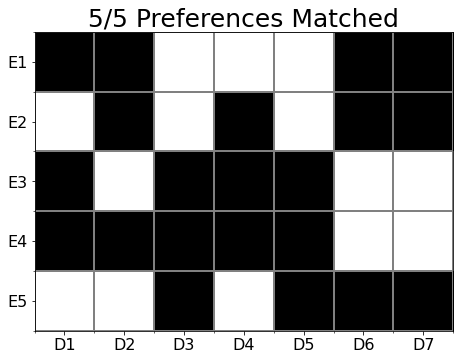

In [48]:
prob, shifts = get_shifts(num_days, num_employees, num_shifts_per_day, time_off_requests, shift_preferences)